# Afriat

In [1]:
ood_seed = 0

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('0', 'Pericentral', 'Control')


Removed datapoint: 546

train         14745
validation     3762
ood             546
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 49%|████▉     | 9392/19053 [00:00<00:00, 93907.55it/s]

 99%|█████████▉| 18819/19053 [00:00<00:00, 94116.71it/s]

100%|██████████| 19053/19053 [00:00<00:00, 93615.44it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1042448.14it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 402.43it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:10<1:08:55, 10.37s/it]

Epoch 1/400:   0%|          | 1/400 [00:10<1:08:55, 10.37s/it, v_num=1, recon=3.98e+3, r2_mean=0.2, adv_loss=3.33, acc_pert=0.258, acc_zone=0.718, acc_status_control=0.49]

Epoch 2/400:   0%|          | 1/400 [00:10<1:08:55, 10.37s/it, v_num=1, recon=3.98e+3, r2_mean=0.2, adv_loss=3.33, acc_pert=0.258, acc_zone=0.718, acc_status_control=0.49]

Epoch 2/400:   0%|          | 2/400 [00:19<1:05:27,  9.87s/it, v_num=1, recon=3.98e+3, r2_mean=0.2, adv_loss=3.33, acc_pert=0.258, acc_zone=0.718, acc_status_control=0.49]

Epoch 2/400:   0%|          | 2/400 [00:19<1:05:27,  9.87s/it, v_num=1, recon=3.26e+3, r2_mean=0.613, adv_loss=2.95, acc_pert=0.34, acc_zone=0.801, acc_status_control=0.634]

Epoch 3/400:   0%|          | 2/400 [00:19<1:05:27,  9.87s/it, v_num=1, recon=3.26e+3, r2_mean=0.613, adv_loss=2.95, acc_pert=0.34, acc_zone=0.801, acc_status_control=0.634]

Epoch 3/400:   1%|          | 3/400 [00:29<1:04:19,  9.72s/it, v_num=1, recon=3.26e+3, r2_mean=0.613, adv_loss=2.95, acc_pert=0.34, acc_zone=0.801, acc_status_control=0.634]

Epoch 3/400:   1%|          | 3/400 [00:29<1:04:19,  9.72s/it, v_num=1, recon=3.2e+3, r2_mean=0.713, adv_loss=2.79, acc_pert=0.373, acc_zone=0.813, acc_status_control=0.637]

Epoch 4/400:   1%|          | 3/400 [00:29<1:04:19,  9.72s/it, v_num=1, recon=3.2e+3, r2_mean=0.713, adv_loss=2.79, acc_pert=0.373, acc_zone=0.813, acc_status_control=0.637]

Epoch 4/400:   1%|          | 4/400 [00:38<1:03:31,  9.62s/it, v_num=1, recon=3.2e+3, r2_mean=0.713, adv_loss=2.79, acc_pert=0.373, acc_zone=0.813, acc_status_control=0.637]

Epoch 4/400:   1%|          | 4/400 [00:38<1:03:31,  9.62s/it, v_num=1, recon=3.18e+3, r2_mean=0.755, adv_loss=2.63, acc_pert=0.441, acc_zone=0.829, acc_status_control=0.641]

Epoch 5/400:   1%|          | 4/400 [00:38<1:03:31,  9.62s/it, v_num=1, recon=3.18e+3, r2_mean=0.755, adv_loss=2.63, acc_pert=0.441, acc_zone=0.829, acc_status_control=0.641]

Epoch 5/400:   1%|▏         | 5/400 [00:48<1:03:01,  9.57s/it, v_num=1, recon=3.18e+3, r2_mean=0.755, adv_loss=2.63, acc_pert=0.441, acc_zone=0.829, acc_status_control=0.641]

Epoch 5/400:   1%|▏         | 5/400 [00:48<1:03:01,  9.57s/it, v_num=1, recon=3.17e+3, r2_mean=0.775, adv_loss=2.45, acc_pert=0.514, acc_zone=0.832, acc_status_control=0.638]

Epoch 6/400:   1%|▏         | 5/400 [00:48<1:03:01,  9.57s/it, v_num=1, recon=3.17e+3, r2_mean=0.775, adv_loss=2.45, acc_pert=0.514, acc_zone=0.832, acc_status_control=0.638]

Epoch 6/400:   2%|▏         | 6/400 [00:57<1:02:43,  9.55s/it, v_num=1, recon=3.17e+3, r2_mean=0.775, adv_loss=2.45, acc_pert=0.514, acc_zone=0.832, acc_status_control=0.638]

Epoch 6/400:   2%|▏         | 6/400 [00:57<1:02:43,  9.55s/it, v_num=1, recon=3.16e+3, r2_mean=0.788, adv_loss=2.32, acc_pert=0.554, acc_zone=0.832, acc_status_control=0.636]

Epoch 7/400:   2%|▏         | 6/400 [00:57<1:02:43,  9.55s/it, v_num=1, recon=3.16e+3, r2_mean=0.788, adv_loss=2.32, acc_pert=0.554, acc_zone=0.832, acc_status_control=0.636]

Epoch 7/400:   2%|▏         | 7/400 [01:07<1:02:23,  9.52s/it, v_num=1, recon=3.16e+3, r2_mean=0.788, adv_loss=2.32, acc_pert=0.554, acc_zone=0.832, acc_status_control=0.636]

Epoch 7/400:   2%|▏         | 7/400 [01:07<1:02:23,  9.52s/it, v_num=1, recon=3.15e+3, r2_mean=0.804, adv_loss=2.23, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.641]

Epoch 8/400:   2%|▏         | 7/400 [01:07<1:02:23,  9.52s/it, v_num=1, recon=3.15e+3, r2_mean=0.804, adv_loss=2.23, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.641]

Epoch 8/400:   2%|▏         | 8/400 [01:16<1:02:10,  9.52s/it, v_num=1, recon=3.15e+3, r2_mean=0.804, adv_loss=2.23, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.641]

Epoch 8/400:   2%|▏         | 8/400 [01:16<1:02:10,  9.52s/it, v_num=1, recon=3.14e+3, r2_mean=0.806, adv_loss=2.19, acc_pert=0.601, acc_zone=0.837, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 8/400 [01:16<1:02:10,  9.52s/it, v_num=1, recon=3.14e+3, r2_mean=0.806, adv_loss=2.19, acc_pert=0.601, acc_zone=0.837, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 9/400 [01:26<1:01:48,  9.49s/it, v_num=1, recon=3.14e+3, r2_mean=0.806, adv_loss=2.19, acc_pert=0.601, acc_zone=0.837, acc_status_control=0.642]

Epoch 9/400:   2%|▏         | 9/400 [01:26<1:01:48,  9.49s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.19, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.643]  

Epoch 10/400:   2%|▏         | 9/400 [01:26<1:01:48,  9.49s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.19, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.643]


disnt_basal = 1.2233464943744983

disnt_after = 1.9181530699496379

val_r2_mean = 0.810950691069883

val_r2_var = 0.18214479217788127


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:40<1:11:31, 11.00s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.19, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.643]

Epoch 10/400:   2%|▎         | 10/400 [01:40<1:11:31, 11.00s/it, v_num=1, recon=3.12e+3, r2_mean=0.809, adv_loss=2.12, acc_pert=0.623, acc_zone=0.842, acc_status_control=0.643, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:40<1:11:31, 11.00s/it, v_num=1, recon=3.12e+3, r2_mean=0.809, adv_loss=2.12, acc_pert=0.623, acc_zone=0.842, acc_status_control=0.643, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:50<1:08:12, 10.52s/it, v_num=1, recon=3.12e+3, r2_mean=0.809, adv_loss=2.12, acc_pert=0.623, acc_zone=0.842, acc_status_control=0.643, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:50<1:08:12, 10.52s/it, v_num=1, recon=3.12e+3, r2_mean=0.817, adv_loss=2.09, acc_pert=0.629, acc_zone=0.845, acc_status_control=0.645, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:50<1:08:12, 10.52s/it, v_num=1, recon=3.12e+3, r2_mean=0.817, adv_loss=2.09, acc_pert=0.629, acc_zone=0.845, acc_status_control=0.645, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:59<1:05:52, 10.19s/it, v_num=1, recon=3.12e+3, r2_mean=0.817, adv_loss=2.09, acc_pert=0.629, acc_zone=0.845, acc_status_control=0.645, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:59<1:05:52, 10.19s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=2.07, acc_pert=0.647, acc_zone=0.842, acc_status_control=0.643, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:59<1:05:52, 10.19s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=2.07, acc_pert=0.647, acc_zone=0.842, acc_status_control=0.643, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:08<1:04:16,  9.96s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=2.07, acc_pert=0.647, acc_zone=0.842, acc_status_control=0.643, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:08<1:04:16,  9.96s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=2.03, acc_pert=0.652, acc_zone=0.845, acc_status_control=0.65, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]  

Epoch 14/400:   3%|▎         | 13/400 [02:08<1:04:16,  9.96s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=2.03, acc_pert=0.652, acc_zone=0.845, acc_status_control=0.65, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:18<1:02:56,  9.78s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=2.03, acc_pert=0.652, acc_zone=0.845, acc_status_control=0.65, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:18<1:02:56,  9.78s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.654, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]  

Epoch 15/400:   4%|▎         | 14/400 [02:18<1:02:56,  9.78s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.654, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:27<1:02:02,  9.67s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.654, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:27<1:02:02,  9.67s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.66, acc_zone=0.846, acc_status_control=0.65, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]  

Epoch 16/400:   4%|▍         | 15/400 [02:27<1:02:02,  9.67s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.66, acc_zone=0.846, acc_status_control=0.65, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:37<1:01:24,  9.59s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.66, acc_zone=0.846, acc_status_control=0.65, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:37<1:01:24,  9.59s/it, v_num=1, recon=3.1e+3, r2_mean=0.823, adv_loss=2.03, acc_pert=0.647, acc_zone=0.842, acc_status_control=0.654, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:37<1:01:24,  9.59s/it, v_num=1, recon=3.1e+3, r2_mean=0.823, adv_loss=2.03, acc_pert=0.647, acc_zone=0.842, acc_status_control=0.654, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:46<1:01:02,  9.56s/it, v_num=1, recon=3.1e+3, r2_mean=0.823, adv_loss=2.03, acc_pert=0.647, acc_zone=0.842, acc_status_control=0.654, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:46<1:01:02,  9.56s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.01, acc_pert=0.657, acc_zone=0.844, acc_status_control=0.655, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:46<1:01:02,  9.56s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.01, acc_pert=0.657, acc_zone=0.844, acc_status_control=0.655, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:56<1:00:35,  9.52s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.01, acc_pert=0.657, acc_zone=0.844, acc_status_control=0.655, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:56<1:00:35,  9.52s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.02, acc_pert=0.657, acc_zone=0.845, acc_status_control=0.658, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:56<1:00:35,  9.52s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.02, acc_pert=0.657, acc_zone=0.845, acc_status_control=0.658, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:05<1:00:15,  9.49s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.02, acc_pert=0.657, acc_zone=0.845, acc_status_control=0.658, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:05<1:00:15,  9.49s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.02, acc_pert=0.65, acc_zone=0.842, acc_status_control=0.657, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan] 

Epoch 20/400:   5%|▍         | 19/400 [03:05<1:00:15,  9.49s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.02, acc_pert=0.65, acc_zone=0.842, acc_status_control=0.657, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]


disnt_basal = 1.2225184697497382

disnt_after = 1.9133326775449493

val_r2_mean = 0.8206666260555586

val_r2_var = 0.21621155517925678


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [03:19<1:09:34, 10.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.02, acc_pert=0.65, acc_zone=0.842, acc_status_control=0.657, val_recon=3.18e+3, disnt_basal=1.22, disnt_after=1.92, val_r2_mean=0.811, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:19<1:09:34, 10.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2, acc_pert=0.651, acc_zone=0.839, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]  

Epoch 21/400:   5%|▌         | 20/400 [03:19<1:09:34, 10.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2, acc_pert=0.651, acc_zone=0.839, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:29<1:06:33, 10.54s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2, acc_pert=0.651, acc_zone=0.839, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:29<1:06:33, 10.54s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.657, acc_zone=0.841, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:29<1:06:33, 10.54s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.657, acc_zone=0.841, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:38<1:04:22, 10.22s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.657, acc_zone=0.841, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:38<1:04:22, 10.22s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.654, acc_zone=0.844, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [03:38<1:04:22, 10.22s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.654, acc_zone=0.844, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:48<1:02:53, 10.01s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.654, acc_zone=0.844, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:48<1:02:53, 10.01s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.646, acc_zone=0.841, acc_status_control=0.664, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:48<1:02:53, 10.01s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.646, acc_zone=0.841, acc_status_control=0.664, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:57<1:01:44,  9.85s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.646, acc_zone=0.841, acc_status_control=0.664, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:57<1:01:44,  9.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.06, acc_pert=0.639, acc_zone=0.841, acc_status_control=0.667, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [03:57<1:01:44,  9.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.06, acc_pert=0.639, acc_zone=0.841, acc_status_control=0.667, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:07<1:00:51,  9.74s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.06, acc_pert=0.639, acc_zone=0.841, acc_status_control=0.667, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:07<1:00:51,  9.74s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=2.05, acc_pert=0.635, acc_zone=0.84, acc_status_control=0.667, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan] 

Epoch 26/400:   6%|▋         | 25/400 [04:07<1:00:51,  9.74s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=2.05, acc_pert=0.635, acc_zone=0.84, acc_status_control=0.667, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:16<1:00:13,  9.66s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=2.05, acc_pert=0.635, acc_zone=0.84, acc_status_control=0.667, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:16<1:00:13,  9.66s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.04, acc_pert=0.642, acc_zone=0.84, acc_status_control=0.659, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [04:16<1:00:13,  9.66s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.04, acc_pert=0.642, acc_zone=0.84, acc_status_control=0.659, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:26<59:53,  9.63s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.04, acc_pert=0.642, acc_zone=0.84, acc_status_control=0.659, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]  

Epoch 27/400:   7%|▋         | 27/400 [04:26<59:53,  9.63s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.634, acc_zone=0.843, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [04:26<59:53,  9.63s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.634, acc_zone=0.843, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:35<59:29,  9.59s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.634, acc_zone=0.843, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:35<59:29,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.08, acc_pert=0.624, acc_zone=0.841, acc_status_control=0.662, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:35<59:29,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.08, acc_pert=0.624, acc_zone=0.841, acc_status_control=0.662, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:45<59:18,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.08, acc_pert=0.624, acc_zone=0.841, acc_status_control=0.662, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:45<59:18,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.09, acc_pert=0.624, acc_zone=0.839, acc_status_control=0.668, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [04:45<59:18,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.09, acc_pert=0.624, acc_zone=0.839, acc_status_control=0.668, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.220630185462125

disnt_after = 1.9006990980035454

val_r2_mean = 0.822773615494772

val_r2_var = 0.23870945742946054

Epoch 30/400:   8%|▊         | 30/400 [05:00<1:08:25, 11.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.09, acc_pert=0.624, acc_zone=0.839, acc_status_control=0.668, val_recon=3.13e+3, disnt_basal=1.22, disnt_after=1.91, val_r2_mean=0.821, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [05:00<1:08:25, 11.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2.09, acc_pert=0.626, acc_zone=0.842, acc_status_control=0.666, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan] 

Epoch 31/400:   8%|▊         | 30/400 [05:00<1:08:25, 11.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2.09, acc_pert=0.626, acc_zone=0.842, acc_status_control=0.666, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:09<1:05:08, 10.59s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2.09, acc_pert=0.626, acc_zone=0.842, acc_status_control=0.666, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:09<1:05:08, 10.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.619, acc_zone=0.843, acc_status_control=0.665, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [05:09<1:05:08, 10.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.619, acc_zone=0.843, acc_status_control=0.665, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:19<1:02:55, 10.26s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.619, acc_zone=0.843, acc_status_control=0.665, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:19<1:02:55, 10.26s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.669, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [05:19<1:02:55, 10.26s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.669, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:28<1:01:25, 10.04s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2.11, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.669, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:28<1:01:25, 10.04s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.664, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [05:28<1:01:25, 10.04s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.664, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:38<1:00:11,  9.87s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.1, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.664, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:38<1:00:11,  9.87s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.611, acc_zone=0.84, acc_status_control=0.669, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:38<1:00:11,  9.87s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.611, acc_zone=0.84, acc_status_control=0.669, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:47<59:23,  9.76s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.611, acc_zone=0.84, acc_status_control=0.669, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]  

Epoch 35/400:   9%|▉         | 35/400 [05:47<59:23,  9.76s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.13, acc_pert=0.601, acc_zone=0.841, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:47<59:23,  9.76s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.13, acc_pert=0.601, acc_zone=0.841, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:57<58:49,  9.70s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.13, acc_pert=0.601, acc_zone=0.841, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:57<58:49,  9.70s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.13, acc_pert=0.602, acc_zone=0.839, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:57<58:49,  9.70s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.13, acc_pert=0.602, acc_zone=0.839, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:06<58:17,  9.64s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.13, acc_pert=0.602, acc_zone=0.839, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:06<58:17,  9.64s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.14, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.665, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [06:06<58:17,  9.64s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.14, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.665, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:16<57:52,  9.59s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.14, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.665, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:16<57:52,  9.59s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.592, acc_zone=0.844, acc_status_control=0.667, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [06:16<57:52,  9.59s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.592, acc_zone=0.844, acc_status_control=0.667, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:25<57:34,  9.57s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.592, acc_zone=0.844, acc_status_control=0.667, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:25<57:34,  9.57s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.599, acc_zone=0.838, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [06:25<57:34,  9.57s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.599, acc_zone=0.838, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.2058623114993767

disnt_after = 1.9052573460641107

val_r2_mean = 0.826515691394553

val_r2_var = 0.239777194483461


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [06:40<1:06:19, 11.05s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.599, acc_zone=0.838, acc_status_control=0.67, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:40<1:06:19, 11.05s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.59, acc_zone=0.838, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:40<1:06:19, 11.05s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.59, acc_zone=0.838, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:49<1:03:26, 10.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.59, acc_zone=0.838, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:49<1:03:26, 10.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.6, acc_zone=0.84, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]  

Epoch 42/400:  10%|█         | 41/400 [06:49<1:03:26, 10.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.6, acc_zone=0.84, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:59<1:01:11, 10.26s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.6, acc_zone=0.84, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:59<1:01:11, 10.26s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:59<1:01:11, 10.26s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [07:08<59:19,  9.97s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]  

Epoch 43/400:  11%|█         | 43/400 [07:08<59:19,  9.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.588, acc_zone=0.84, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [07:08<59:19,  9.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.588, acc_zone=0.84, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:17<57:59,  9.77s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.588, acc_zone=0.84, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:17<57:59,  9.77s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [07:17<57:59,  9.77s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:27<57:05,  9.65s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.666, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:27<57:05,  9.65s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.589, acc_zone=0.837, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [07:27<57:05,  9.65s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.589, acc_zone=0.837, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:36<56:31,  9.58s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.589, acc_zone=0.837, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:36<56:31,  9.58s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.586, acc_zone=0.837, acc_status_control=0.667, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [07:36<56:31,  9.58s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.586, acc_zone=0.837, acc_status_control=0.667, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:45<55:56,  9.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.586, acc_zone=0.837, acc_status_control=0.667, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:45<55:56,  9.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.59, acc_zone=0.831, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [07:45<55:56,  9.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.59, acc_zone=0.831, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:55<55:28,  9.46s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.59, acc_zone=0.831, acc_status_control=0.668, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:55<55:28,  9.46s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.665, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]   

Epoch 49/400:  12%|█▏        | 48/400 [07:55<55:28,  9.46s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.665, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [08:04<55:08,  9.43s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.665, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [08:04<55:08,  9.43s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.586, acc_zone=0.833, acc_status_control=0.665, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [08:04<55:08,  9.43s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.586, acc_zone=0.833, acc_status_control=0.665, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2036537394863027

disnt_after = 1.9008712264478078

val_r2_mean = 0.8283759993876304

val_r2_var = 0.2571020704328956


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [08:19<1:03:49, 10.94s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.19, acc_pert=0.586, acc_zone=0.833, acc_status_control=0.665, val_recon=3.09e+3, disnt_basal=1.21, disnt_after=1.91, val_r2_mean=0.827, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [08:19<1:03:49, 10.94s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.586, acc_zone=0.834, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [08:19<1:03:49, 10.94s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.586, acc_zone=0.834, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:28<1:00:44, 10.44s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.586, acc_zone=0.834, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:28<1:00:44, 10.44s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan] 

Epoch 52/400:  13%|█▎        | 51/400 [08:28<1:00:44, 10.44s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:37<58:38, 10.11s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]  

Epoch 52/400:  13%|█▎        | 52/400 [08:37<58:38, 10.11s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.572, acc_zone=0.832, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [08:37<58:38, 10.11s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.572, acc_zone=0.832, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:46<56:57,  9.85s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.572, acc_zone=0.832, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:46<56:57,  9.85s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.577, acc_zone=0.831, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [08:46<56:57,  9.85s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.577, acc_zone=0.831, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:56<55:47,  9.67s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.577, acc_zone=0.831, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:56<55:47,  9.67s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.567, acc_zone=0.834, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [08:56<55:47,  9.67s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.567, acc_zone=0.834, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:05<54:58,  9.56s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.567, acc_zone=0.834, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:05<54:58,  9.56s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [09:05<54:58,  9.56s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:14<54:21,  9.48s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:14<54:21,  9.48s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [09:14<54:21,  9.48s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:24<53:59,  9.45s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:24<53:59,  9.45s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [09:24<53:59,  9.45s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:33<53:40,  9.42s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.571, acc_zone=0.833, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:33<53:40,  9.42s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [09:33<53:40,  9.42s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:42<53:18,  9.38s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.22, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:42<53:18,  9.38s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:42<53:18,  9.38s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2025918078331241

disnt_after = 1.900894283066046

val_r2_mean = 0.8298925339622879

val_r2_var = 0.2629487851552588


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:56<1:01:14, 10.81s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.828, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:56<1:01:14, 10.81s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.566, acc_zone=0.83, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [09:56<1:01:14, 10.81s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.566, acc_zone=0.83, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [10:06<58:30, 10.35s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.566, acc_zone=0.83, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 61/400 [10:06<58:30, 10.35s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [10:06<58:30, 10.35s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:15<56:33, 10.04s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.665, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:15<56:33, 10.04s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [10:15<56:33, 10.04s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:24<55:11,  9.83s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:24<55:11,  9.83s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.563, acc_zone=0.832, acc_status_control=0.664, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [10:24<55:11,  9.83s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.563, acc_zone=0.832, acc_status_control=0.664, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:34<54:18,  9.70s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.563, acc_zone=0.832, acc_status_control=0.664, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:34<54:18,  9.70s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.562, acc_zone=0.83, acc_status_control=0.668, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 65/400:  16%|█▌        | 64/400 [10:34<54:18,  9.70s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.562, acc_zone=0.83, acc_status_control=0.668, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:43<53:35,  9.60s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.562, acc_zone=0.83, acc_status_control=0.668, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:43<53:35,  9.60s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [10:43<53:35,  9.60s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:52<52:57,  9.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.667, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:52<52:57,  9.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:52<52:57,  9.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [11:02<52:33,  9.47s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.569, acc_zone=0.831, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [11:02<52:33,  9.47s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.565, acc_zone=0.828, acc_status_control=0.661, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [11:02<52:33,  9.47s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.565, acc_zone=0.828, acc_status_control=0.661, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:11<52:12,  9.44s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.565, acc_zone=0.828, acc_status_control=0.661, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:11<52:12,  9.44s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.563, acc_zone=0.83, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [11:11<52:12,  9.44s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.563, acc_zone=0.83, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:20<51:49,  9.39s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.563, acc_zone=0.83, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:20<51:49,  9.39s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.566, acc_zone=0.829, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [11:20<51:49,  9.39s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.566, acc_zone=0.829, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2006457870977068

disnt_after = 1.8986524222722025

val_r2_mean = 0.8246249304644522

val_r2_var = 0.2602632405073632

Epoch 70/400:  18%|█▊        | 70/400 [11:35<59:43, 10.86s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.566, acc_zone=0.829, acc_status_control=0.666, val_recon=3.06e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.83, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [11:35<59:43, 10.86s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.667, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [11:35<59:43, 10.86s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.667, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:44<57:00, 10.40s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.24, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.667, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:44<57:00, 10.40s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.558, acc_zone=0.83, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [11:44<57:00, 10.40s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.558, acc_zone=0.83, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:53<55:03, 10.07s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.558, acc_zone=0.83, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:53<55:03, 10.07s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.561, acc_zone=0.829, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [11:53<55:03, 10.07s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.561, acc_zone=0.829, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:03<53:35,  9.83s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.24, acc_pert=0.561, acc_zone=0.829, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:03<53:35,  9.83s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [12:03<53:35,  9.83s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:12<52:30,  9.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:12<52:30,  9.67s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan] 

Epoch 75/400:  18%|█▊        | 74/400 [12:12<52:30,  9.67s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:21<51:51,  9.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:21<51:51,  9.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.553, acc_zone=0.828, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [12:21<51:51,  9.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.553, acc_zone=0.828, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:31<51:13,  9.49s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.553, acc_zone=0.828, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:31<51:13,  9.49s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [12:31<51:13,  9.49s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:40<50:48,  9.44s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:40<50:48,  9.44s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [12:40<50:48,  9.44s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:49<50:28,  9.41s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:49<50:28,  9.41s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]  

Epoch 79/400:  20%|█▉        | 78/400 [12:49<50:28,  9.41s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:58<50:10,  9.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:58<50:10,  9.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.553, acc_zone=0.825, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [12:59<50:10,  9.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.553, acc_zone=0.825, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1953151719962287

disnt_after = 1.8901140662615774

val_r2_mean = 0.8299351759407466

val_r2_var = 0.26091233375479256

Epoch 80/400:  20%|██        | 80/400 [13:13<58:01, 10.88s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.553, acc_zone=0.825, acc_status_control=0.666, val_recon=3.04e+3, disnt_basal=1.2, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [13:13<58:01, 10.88s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [13:13<58:01, 10.88s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:22<55:25, 10.42s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:22<55:25, 10.42s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [13:22<55:25, 10.42s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:31<53:18, 10.06s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:31<53:18, 10.06s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [13:31<53:18, 10.06s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:41<51:58,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:41<51:58,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [13:41<51:58,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:50<51:04,  9.70s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:50<51:04,  9.70s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [13:50<51:04,  9.70s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:59<50:22,  9.59s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.26, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:59<50:22,  9.59s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [13:59<50:22,  9.59s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:09<49:40,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:09<49:40,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [14:09<49:40,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:18<49:15,  9.44s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:18<49:15,  9.44s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.551, acc_zone=0.828, acc_status_control=0.661, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [14:18<49:15,  9.44s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.551, acc_zone=0.828, acc_status_control=0.661, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:27<48:49,  9.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.551, acc_zone=0.828, acc_status_control=0.661, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:27<48:49,  9.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.548, acc_zone=0.828, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [14:27<48:49,  9.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.548, acc_zone=0.828, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:37<48:28,  9.35s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.548, acc_zone=0.828, acc_status_control=0.666, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:37<48:28,  9.35s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]  

Epoch 90/400:  22%|██▏       | 89/400 [14:37<48:28,  9.35s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1901136518571893

disnt_after = 1.888878684226822

val_r2_mean = 0.831549786546675

val_r2_var = 0.2799507151209101


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [14:51<55:56, 10.83s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.665, val_recon=3.02e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [14:51<55:56, 10.83s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [14:51<55:56, 10.83s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [15:00<53:24, 10.37s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.663, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [15:00<53:24, 10.37s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [15:00<53:24, 10.37s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:10<51:37, 10.06s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:10<51:37, 10.06s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [15:10<51:37, 10.06s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:19<50:22,  9.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:19<50:22,  9.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [15:19<50:22,  9.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:28<49:22,  9.68s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:28<49:22,  9.68s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]  

Epoch 95/400:  24%|██▎       | 94/400 [15:28<49:22,  9.68s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:37<48:40,  9.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:37<48:40,  9.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [15:37<48:40,  9.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:47<48:02,  9.48s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:47<48:02,  9.48s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.828, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 97/400:  24%|██▍       | 96/400 [15:47<48:02,  9.48s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.828, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:56<47:33,  9.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.828, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:56<47:33,  9.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [15:56<47:33,  9.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:05<47:11,  9.38s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:05<47:11,  9.38s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [16:05<47:11,  9.38s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:15<46:50,  9.34s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:15<46:50,  9.34s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [16:15<46:50,  9.34s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1913092191783439

disnt_after = 1.8900147580512652

val_r2_mean = 0.8282347552140709

val_r2_var = 0.27797643815460116

Epoch 100/400:  25%|██▌       | 100/400 [16:29<53:50, 10.77s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.661, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [16:29<53:50, 10.77s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [16:29<53:50, 10.77s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:38<51:29, 10.33s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:38<51:29, 10.33s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.544, acc_zone=0.826, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [16:38<51:29, 10.33s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.544, acc_zone=0.826, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [16:47<49:51, 10.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.544, acc_zone=0.826, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [16:47<49:51, 10.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [16:47<49:51, 10.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:56<48:24,  9.78s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:56<48:24,  9.78s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.541, acc_zone=0.826, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [16:56<48:24,  9.78s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.541, acc_zone=0.826, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:06<47:33,  9.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.541, acc_zone=0.826, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:06<47:33,  9.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [17:06<47:33,  9.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:15<46:57,  9.55s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.662, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:15<46:57,  9.55s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.542, acc_zone=0.824, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [17:15<46:57,  9.55s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.542, acc_zone=0.824, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:24<46:28,  9.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.542, acc_zone=0.824, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:24<46:28,  9.48s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.539, acc_zone=0.832, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [17:24<46:28,  9.48s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.539, acc_zone=0.832, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:34<45:57,  9.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.539, acc_zone=0.832, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:34<45:57,  9.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [17:34<45:57,  9.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:43<45:36,  9.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:43<45:36,  9.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [17:43<45:36,  9.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [17:52<45:24,  9.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [17:52<45:24,  9.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.532, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [17:52<45:24,  9.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.532, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.192004803361749

disnt_after = 1.8872374812123995

val_r2_mean = 0.830740262554358

val_r2_var = 0.2849756667607202

Epoch 110/400:  28%|██▊       | 110/400 [18:07<52:24, 10.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.532, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [18:07<52:24, 10.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.539, acc_zone=0.829, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [18:07<52:24, 10.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.539, acc_zone=0.829, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:16<50:17, 10.44s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.539, acc_zone=0.829, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:16<50:17, 10.44s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [18:16<50:17, 10.44s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:25<48:29, 10.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:25<48:29, 10.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [18:25<48:29, 10.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:35<47:11,  9.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.667, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:35<47:11,  9.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.533, acc_zone=0.831, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [18:35<47:11,  9.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.533, acc_zone=0.831, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:44<46:16,  9.71s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.533, acc_zone=0.831, acc_status_control=0.665, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:44<46:16,  9.71s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [18:44<46:16,  9.71s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [18:53<45:30,  9.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [18:53<45:30,  9.58s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan] 

Epoch 116/400:  29%|██▉       | 115/400 [18:53<45:30,  9.58s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:03<45:02,  9.52s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.544, acc_zone=0.827, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:03<45:02,  9.52s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.541, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [19:03<45:02,  9.52s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.541, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:12<44:36,  9.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.541, acc_zone=0.829, acc_status_control=0.664, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:12<44:36,  9.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]  

Epoch 118/400:  29%|██▉       | 117/400 [19:12<44:36,  9.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:21<44:18,  9.43s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.668, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:21<44:18,  9.43s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.67, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [19:21<44:18,  9.43s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.67, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:31<43:56,  9.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.67, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:31<43:56,  9.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.536, acc_zone=0.829, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [19:31<43:56,  9.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.536, acc_zone=0.829, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1829122503470704

disnt_after = 1.8920056223525883

val_r2_mean = 0.8273686910537686

val_r2_var = 0.2806024294961186


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [19:45<50:42, 10.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.536, acc_zone=0.829, acc_status_control=0.666, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [19:45<50:42, 10.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.539, acc_zone=0.827, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]   

Epoch 121/400:  30%|███       | 120/400 [19:45<50:42, 10.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.539, acc_zone=0.827, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [19:54<48:26, 10.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.539, acc_zone=0.827, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [19:54<48:26, 10.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [19:54<48:26, 10.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:04<46:38, 10.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:04<46:38, 10.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [20:04<46:38, 10.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:13<45:19,  9.82s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:13<45:19,  9.82s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.539, acc_zone=0.83, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [20:13<45:19,  9.82s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.539, acc_zone=0.83, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:22<44:25,  9.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.539, acc_zone=0.83, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:22<44:25,  9.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [20:22<44:25,  9.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:31<43:46,  9.55s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:31<43:46,  9.55s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [20:31<43:46,  9.55s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:41<43:25,  9.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:41<43:25,  9.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [20:41<43:25,  9.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [20:50<43:03,  9.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [20:50<43:03,  9.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.543, acc_zone=0.826, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [20:50<43:03,  9.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.543, acc_zone=0.826, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:00<42:42,  9.42s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.543, acc_zone=0.826, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:00<42:42,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.543, acc_zone=0.829, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [21:00<42:42,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.543, acc_zone=0.829, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:09<42:28,  9.40s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.543, acc_zone=0.829, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:09<42:28,  9.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.543, acc_zone=0.825, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [21:09<42:28,  9.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.543, acc_zone=0.825, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1870865771164847

disnt_after = 1.8891307978775735

val_r2_mean = 0.8303029084343687

val_r2_var = 0.28338308803738016

Epoch 130/400:  32%|███▎      | 130/400 [21:23<48:43, 10.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.543, acc_zone=0.825, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [21:23<48:43, 10.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.539, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [21:23<48:43, 10.83s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.539, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:32<46:23, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.539, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:32<46:23, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.538, acc_zone=0.827, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [21:32<46:23, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.538, acc_zone=0.827, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [21:42<44:42, 10.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.538, acc_zone=0.827, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [21:42<44:42, 10.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.664, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 133/400:  33%|███▎      | 132/400 [21:42<44:42, 10.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.664, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [21:51<43:28,  9.77s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.664, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [21:51<43:28,  9.77s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.543, acc_zone=0.826, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [21:51<43:28,  9.77s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.543, acc_zone=0.826, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:00<42:38,  9.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.543, acc_zone=0.826, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:00<42:38,  9.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.83, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [22:00<42:38,  9.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.83, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:09<42:03,  9.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.83, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:09<42:03,  9.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.543, acc_zone=0.827, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [22:09<42:03,  9.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.543, acc_zone=0.827, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:19<41:32,  9.44s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.543, acc_zone=0.827, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:19<41:32,  9.44s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.547, acc_zone=0.829, acc_status_control=0.664, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [22:19<41:32,  9.44s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.547, acc_zone=0.829, acc_status_control=0.664, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:28<41:09,  9.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.547, acc_zone=0.829, acc_status_control=0.664, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:28<41:09,  9.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.665, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [22:28<41:09,  9.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.665, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:37<40:48,  9.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.665, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:37<40:48,  9.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.826, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [22:37<40:48,  9.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.826, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [22:46<40:35,  9.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.826, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [22:46<40:35,  9.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [22:46<40:35,  9.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.182052596923167

disnt_after = 1.881288816272322

val_r2_mean = 0.8300255744253613

val_r2_var = 0.2866706179051467

Epoch 140/400:  35%|███▌      | 140/400 [23:01<46:54, 10.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.19, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [23:01<46:54, 10.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]  

Epoch 141/400:  35%|███▌      | 140/400 [23:01<46:54, 10.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:10<44:47, 10.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:10<44:47, 10.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [23:10<44:47, 10.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:19<43:25, 10.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:19<43:25, 10.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.538, acc_zone=0.828, acc_status_control=0.665, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [23:19<43:25, 10.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.538, acc_zone=0.828, acc_status_control=0.665, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:29<42:12,  9.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.538, acc_zone=0.828, acc_status_control=0.665, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:29<42:12,  9.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [23:29<42:12,  9.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [23:38<41:23,  9.70s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [23:38<41:23,  9.70s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.546, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [23:38<41:23,  9.70s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.546, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [23:47<40:40,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.546, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [23:47<40:40,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [23:47<40:40,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [23:57<40:10,  9.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [23:57<40:10,  9.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.536, acc_zone=0.827, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [23:57<40:10,  9.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.536, acc_zone=0.827, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:06<39:49,  9.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.536, acc_zone=0.827, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:06<39:49,  9.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.537, acc_zone=0.828, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [24:06<39:49,  9.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.537, acc_zone=0.828, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:15<39:34,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.537, acc_zone=0.828, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:15<39:34,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.539, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [24:15<39:34,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.539, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:25<39:14,  9.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.539, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:25<39:14,  9.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.536, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [24:25<39:14,  9.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.536, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.179954434705041

disnt_after = 1.8791399547121082

val_r2_mean = 0.8304169987394416

val_r2_var = 0.28455352910399034

Epoch 150/400:  38%|███▊      | 150/400 [24:39<45:08, 10.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.536, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [24:39<45:08, 10.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [24:39<45:08, 10.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [24:48<42:59, 10.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [24:48<42:59, 10.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.541, acc_zone=0.826, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [24:48<42:59, 10.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.541, acc_zone=0.826, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [24:57<41:27, 10.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.541, acc_zone=0.826, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [24:57<41:27, 10.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.827, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [24:57<41:27, 10.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.827, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:07<40:25,  9.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.545, acc_zone=0.827, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:07<40:25,  9.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [25:07<40:25,  9.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:16<39:37,  9.67s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:16<39:37,  9.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.829, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [25:16<39:37,  9.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.829, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:25<39:03,  9.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.537, acc_zone=0.829, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:25<39:03,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [25:25<39:03,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [25:35<38:33,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [25:35<38:33,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [25:35<38:33,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [25:44<38:13,  9.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.542, acc_zone=0.826, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [25:44<38:13,  9.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.541, acc_zone=0.831, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [25:44<38:13,  9.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.541, acc_zone=0.831, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [25:53<37:54,  9.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.541, acc_zone=0.831, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [25:53<37:54,  9.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [25:53<37:54,  9.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:03<37:36,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:03<37:36,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [26:03<37:36,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1713001229206192

disnt_after = 1.8779171386588651

val_r2_mean = 0.8305203993760478

val_r2_var = 0.2847375131336501

Epoch 160/400:  40%|████      | 160/400 [26:17<43:15, 10.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [26:17<43:15, 10.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [26:17<43:15, 10.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:26<41:14, 10.36s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.666, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:26<41:14, 10.36s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [26:26<41:14, 10.36s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [26:35<39:45, 10.02s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [26:35<39:45, 10.02s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.825, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [26:35<39:45, 10.02s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.825, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [26:45<38:40,  9.79s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.825, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [26:45<38:40,  9.79s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [26:45<38:40,  9.79s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [26:54<37:49,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [26:54<37:49,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.545, acc_zone=0.834, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [26:54<37:49,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.545, acc_zone=0.834, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:03<37:17,  9.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.545, acc_zone=0.834, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:03<37:17,  9.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [27:03<37:17,  9.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:12<36:48,  9.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.546, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:12<36:48,  9.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [27:12<36:48,  9.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:22<36:24,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:22<36:24,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [27:22<36:24,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:31<36:05,  9.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:31<36:05,  9.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 169/400:  42%|████▏     | 168/400 [27:31<36:05,  9.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [27:40<35:53,  9.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [27:40<35:53,  9.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [27:40<35:53,  9.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1829804461829219

disnt_after = 1.8697794302324797

val_r2_mean = 0.8280939433621121

val_r2_var = 0.2858600405592614

Epoch 170/400:  42%|████▎     | 170/400 [27:54<41:19, 10.78s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [27:54<41:19, 10.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.541, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [27:54<41:19, 10.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.541, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:04<39:30, 10.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.541, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:04<39:30, 10.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.541, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [28:04<39:30, 10.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.541, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:13<38:07, 10.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.541, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:13<38:07, 10.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.538, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [28:13<38:07, 10.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.538, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:22<37:07,  9.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.538, acc_zone=0.827, acc_status_control=0.668, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:22<37:07,  9.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.541, acc_zone=0.828, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [28:22<37:07,  9.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.541, acc_zone=0.828, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:32<36:26,  9.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.541, acc_zone=0.828, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:32<36:26,  9.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.537, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [28:32<36:26,  9.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.537, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [28:41<35:55,  9.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.537, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [28:41<35:55,  9.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.537, acc_zone=0.829, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [28:41<35:55,  9.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.537, acc_zone=0.829, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [28:50<35:26,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.537, acc_zone=0.829, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [28:50<35:26,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [28:50<35:26,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [28:59<35:03,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [28:59<35:03,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.543, acc_zone=0.829, acc_status_control=0.673, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [28:59<35:03,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.543, acc_zone=0.829, acc_status_control=0.673, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:09<34:45,  9.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.543, acc_zone=0.829, acc_status_control=0.673, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:09<34:45,  9.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [29:09<34:45,  9.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:18<34:33,  9.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:18<34:33,  9.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [29:18<34:33,  9.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1757666907360511

disnt_after = 1.8734028037657569

val_r2_mean = 0.8268632867076187

val_r2_var = 0.28589285714064566

Epoch 180/400:  45%|████▌     | 180/400 [29:32<39:44, 10.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.827, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.828, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [29:32<39:44, 10.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]  

Epoch 181/400:  45%|████▌     | 180/400 [29:32<39:44, 10.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [29:42<37:53, 10.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [29:42<37:53, 10.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.538, acc_zone=0.83, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [29:42<37:53, 10.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.538, acc_zone=0.83, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [29:51<36:34, 10.07s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.538, acc_zone=0.83, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [29:51<36:34, 10.07s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [29:51<36:34, 10.07s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:00<35:30,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:00<35:30,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [30:00<35:30,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:10<34:46,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:10<34:46,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.832, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [30:10<34:46,  9.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.832, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:19<34:13,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.542, acc_zone=0.832, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:19<34:13,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]  

Epoch 186/400:  46%|████▋     | 185/400 [30:19<34:13,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:28<33:47,  9.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.54, acc_zone=0.826, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:28<33:47,  9.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.542, acc_zone=0.83, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [30:28<33:47,  9.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.542, acc_zone=0.83, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [30:37<33:26,  9.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.542, acc_zone=0.83, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [30:37<33:26,  9.42s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [30:37<33:26,  9.42s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [30:47<33:11,  9.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.537, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [30:47<33:11,  9.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.535, acc_zone=0.828, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [30:47<33:11,  9.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.535, acc_zone=0.828, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [30:56<32:53,  9.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.535, acc_zone=0.828, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [30:56<32:53,  9.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.544, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [30:56<32:53,  9.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.544, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.179516691087482

disnt_after = 1.8664455597753775

val_r2_mean = 0.8326911967319781

val_r2_var = 0.29362774203574454

Epoch 190/400:  48%|████▊     | 190/400 [31:10<37:52, 10.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.544, acc_zone=0.826, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [31:10<37:52, 10.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.539, acc_zone=0.824, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [31:10<37:52, 10.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.539, acc_zone=0.824, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:20<36:06, 10.37s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.539, acc_zone=0.824, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:20<36:06, 10.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [31:20<36:06, 10.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:29<34:51, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.667, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:29<34:51, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.666, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [31:29<34:51, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.666, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [31:38<33:49,  9.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.54, acc_zone=0.827, acc_status_control=0.666, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [31:38<33:49,  9.81s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.54, acc_zone=0.829, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [31:38<33:49,  9.81s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.54, acc_zone=0.829, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [31:47<33:11,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.54, acc_zone=0.829, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [31:47<33:11,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.545, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [31:47<33:11,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.545, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [31:57<32:43,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.545, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [31:57<32:43,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [31:57<32:43,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:06<32:22,  9.52s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:06<32:22,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.828, acc_status_control=0.674, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [32:06<32:22,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.828, acc_status_control=0.674, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:16<32:02,  9.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.828, acc_status_control=0.674, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:16<32:02,  9.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [32:16<32:02,  9.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:25<31:45,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.672, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:25<31:45,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]  

Epoch 199/400:  50%|████▉     | 198/400 [32:25<31:45,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [32:34<31:35,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.67, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [32:34<31:35,  9.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [32:34<31:35,  9.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1780598254470631

disnt_after = 1.8753394548953617

val_r2_mean = 0.8284319709462759

val_r2_var = 0.2896758761618862

Epoch 200/400:  50%|█████     | 200/400 [32:49<36:17, 10.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.54, acc_zone=0.828, acc_status_control=0.671, val_recon=2.99e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [32:49<36:17, 10.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [32:49<36:17, 10.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [32:58<34:34, 10.42s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [32:58<34:34, 10.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.538, acc_zone=0.825, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [32:58<34:34, 10.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.538, acc_zone=0.825, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:07<33:13, 10.07s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.538, acc_zone=0.825, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:07<33:13, 10.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.541, acc_zone=0.825, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [33:07<33:13, 10.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.541, acc_zone=0.825, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:17<32:21,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.541, acc_zone=0.825, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:17<32:21,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [33:17<32:21,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:26<31:44,  9.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:26<31:44,  9.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.547, acc_zone=0.827, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [33:26<31:44,  9.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.547, acc_zone=0.827, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [33:35<31:23,  9.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.547, acc_zone=0.827, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [33:35<31:23,  9.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [33:35<31:23,  9.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [33:45<30:58,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [33:45<30:58,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]  

Epoch 207/400:  52%|█████▏    | 206/400 [33:45<30:58,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [33:54<30:39,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [33:54<30:39,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.543, acc_zone=0.831, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [33:54<30:39,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.543, acc_zone=0.831, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:04<30:17,  9.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.543, acc_zone=0.831, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:04<30:17,  9.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.545, acc_zone=0.826, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [34:04<30:17,  9.47s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.545, acc_zone=0.826, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:13<29:59,  9.42s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.545, acc_zone=0.826, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:13<29:59,  9.42s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]  

Epoch 210/400:  52%|█████▏    | 209/400 [34:13<29:59,  9.42s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.172053465095447

disnt_after = 1.8688239852941908

val_r2_mean = 0.8359287786189034

val_r2_var = 0.29602651985580064

Epoch 210/400:  52%|█████▎    | 210/400 [34:27<34:22, 10.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.54, acc_zone=0.831, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [34:27<34:22, 10.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.539, acc_zone=0.825, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [34:27<34:22, 10.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.539, acc_zone=0.825, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [34:36<32:43, 10.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.539, acc_zone=0.825, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [34:36<32:43, 10.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.539, acc_zone=0.83, acc_status_control=0.676, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan] 

Epoch 212/400:  53%|█████▎    | 211/400 [34:36<32:43, 10.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.539, acc_zone=0.83, acc_status_control=0.676, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [34:46<31:35, 10.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.539, acc_zone=0.83, acc_status_control=0.676, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [34:46<31:35, 10.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.665, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [34:46<31:35, 10.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.665, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [34:55<30:44,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.665, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [34:55<30:44,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [34:55<30:44,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:04<30:03,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.669, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:04<30:03,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [35:04<30:03,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:14<29:28,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:14<29:28,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.546, acc_zone=0.828, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [35:14<29:28,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.546, acc_zone=0.828, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:23<29:05,  9.49s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.546, acc_zone=0.828, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:23<29:05,  9.49s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.542, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]  

Epoch 217/400:  54%|█████▍    | 216/400 [35:23<29:05,  9.49s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.542, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [35:32<28:42,  9.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.542, acc_zone=0.83, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [35:32<28:42,  9.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [35:32<28:42,  9.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [35:42<28:28,  9.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [35:42<28:28,  9.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [35:42<28:28,  9.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [35:51<28:11,  9.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [35:51<28:11,  9.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.538, acc_zone=0.829, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [35:51<28:11,  9.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.538, acc_zone=0.829, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1709376212923313

disnt_after = 1.8694213025648998

val_r2_mean = 0.827154505471531

val_r2_var = 0.27494787220553835

Epoch 220/400:  55%|█████▌    | 220/400 [36:05<32:23, 10.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.538, acc_zone=0.829, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [36:05<32:23, 10.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.545, acc_zone=0.831, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [36:05<29:31,  9.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.545, acc_zone=0.831, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  6%|▌         | 33/596 [00:00<00:01, 324.77it/s]

 13%|█▎        | 79/596 [00:00<00:01, 402.05it/s]

 21%|██        | 125/596 [00:00<00:01, 425.12it/s]

 29%|██▊       | 171/596 [00:00<00:00, 436.06it/s]

 36%|███▋      | 217/596 [00:00<00:00, 444.10it/s]

 44%|████▍     | 263/596 [00:00<00:00, 448.09it/s]

 52%|█████▏    | 309/596 [00:00<00:00, 450.17it/s]

 60%|█████▉    | 355/596 [00:00<00:00, 452.53it/s]

 67%|██████▋   | 401/596 [00:00<00:00, 453.29it/s]

 75%|███████▌  | 447/596 [00:01<00:00, 453.75it/s]

 83%|████████▎ | 493/596 [00:01<00:00, 453.28it/s]

 90%|█████████ | 539/596 [00:01<00:00, 455.13it/s]

 98%|█████████▊| 585/596 [00:01<00:00, 455.01it/s]

100%|██████████| 596/596 [00:01<00:00, 443.25it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

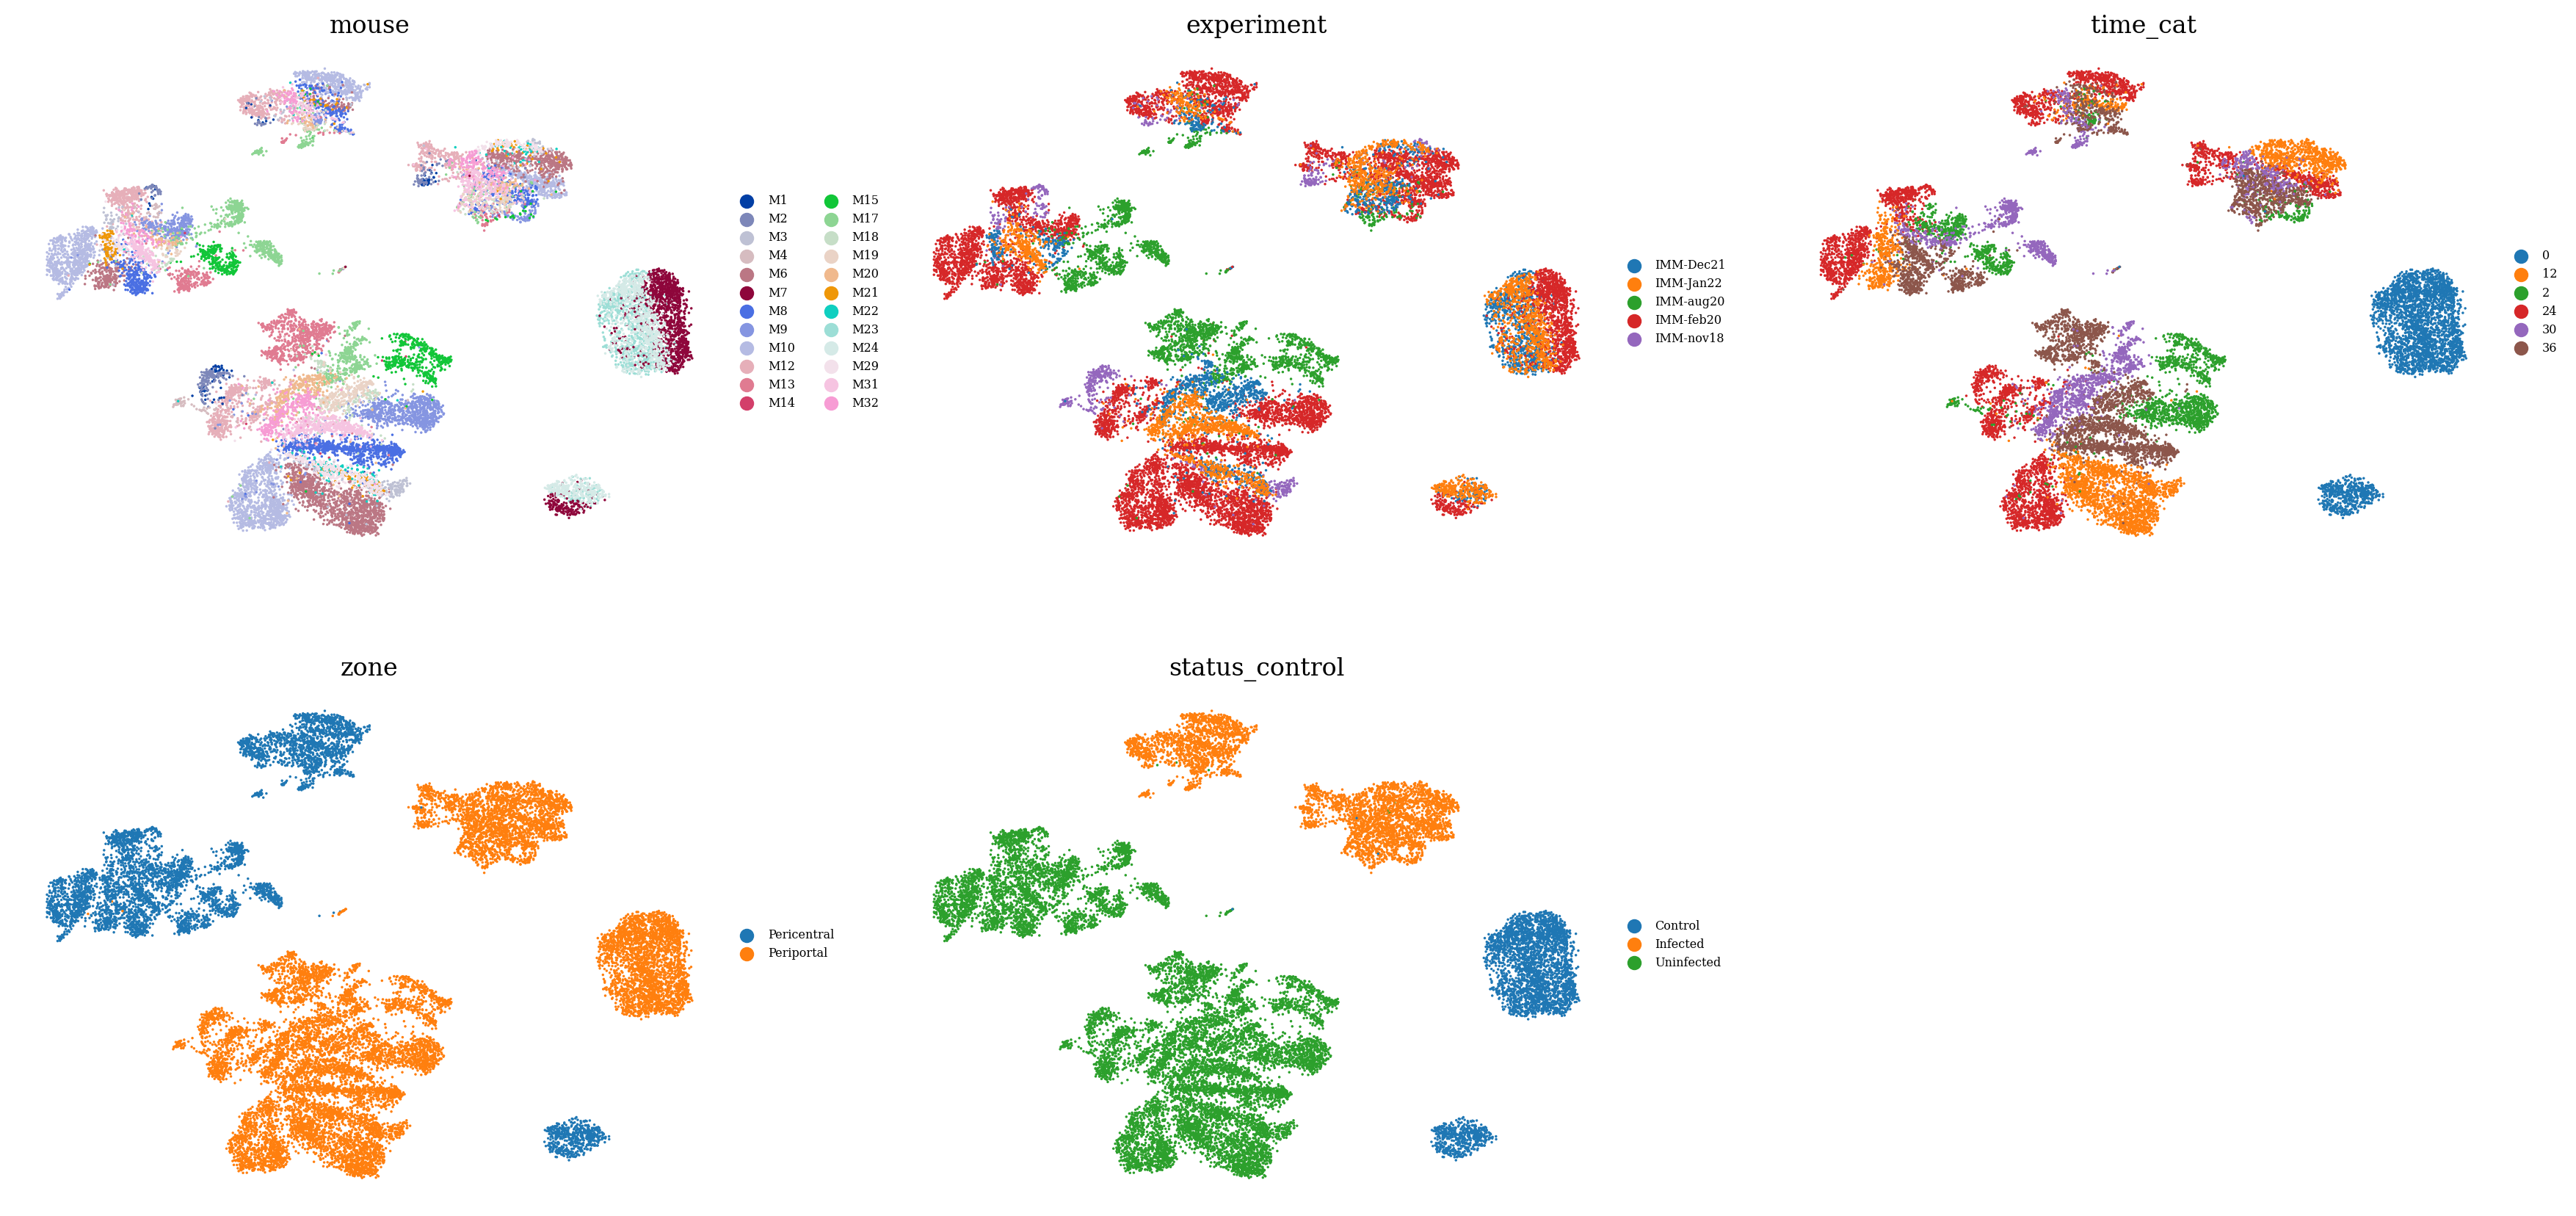

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

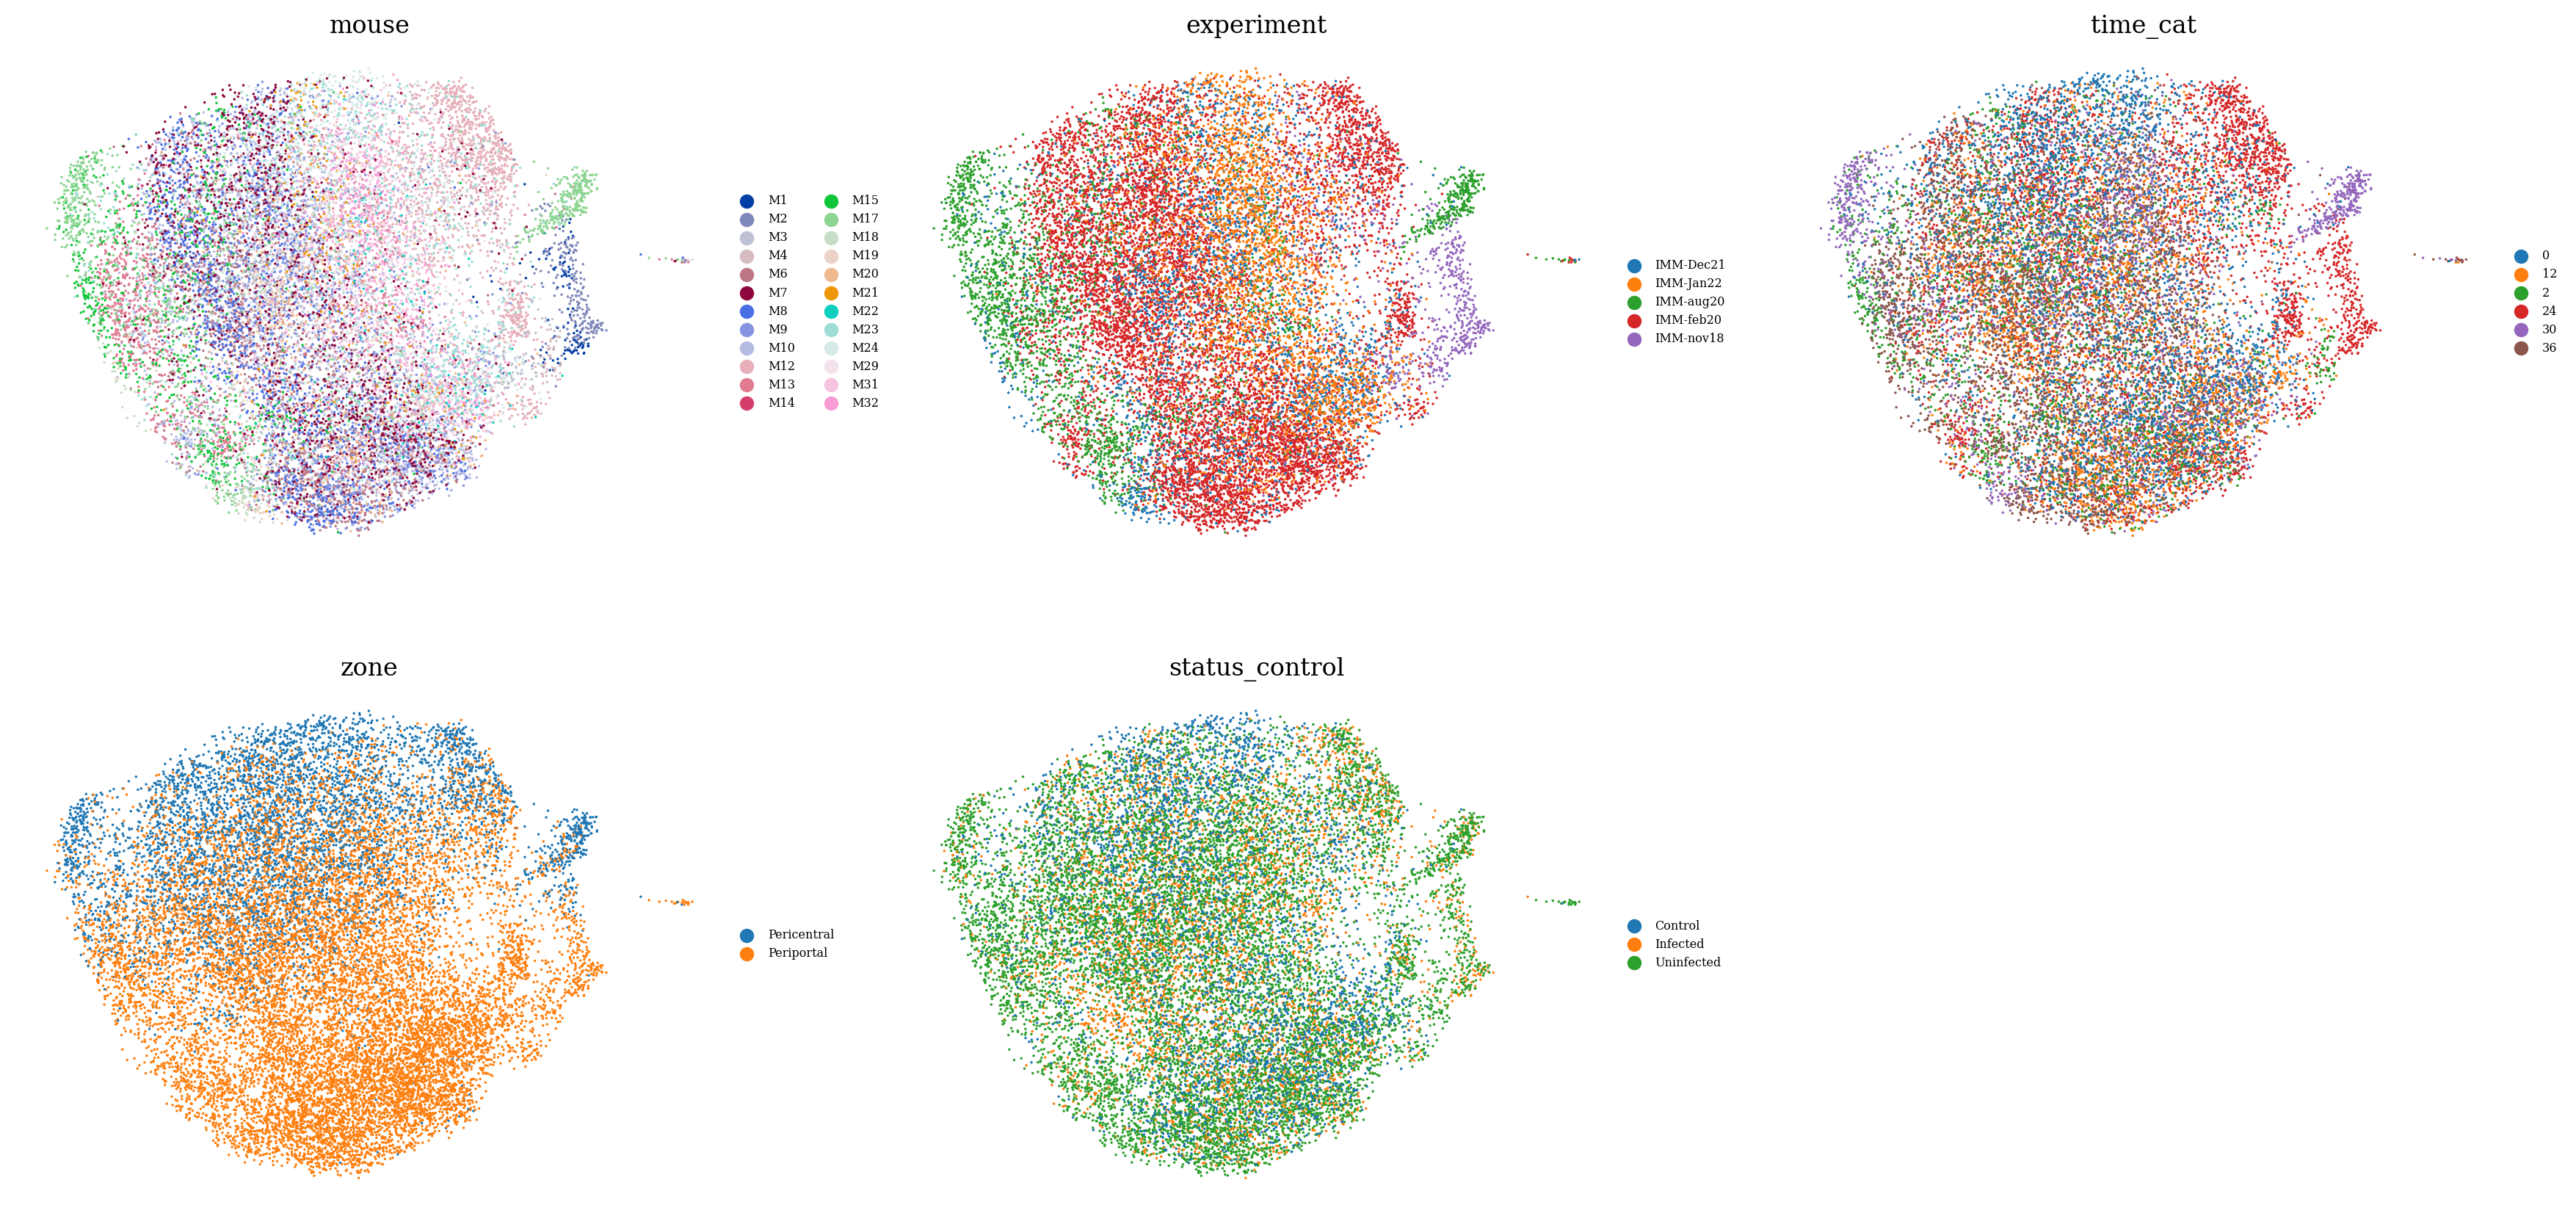

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  4%|▍         | 26/596 [00:00<00:02, 252.95it/s]

  9%|▉         | 53/596 [00:00<00:02, 259.97it/s]

 14%|█▎        | 81/596 [00:00<00:01, 265.96it/s]

 18%|█▊        | 109/596 [00:00<00:01, 268.58it/s]

 23%|██▎       | 136/596 [00:00<00:01, 268.74it/s]

 27%|██▋       | 163/596 [00:00<00:01, 269.10it/s]

 32%|███▏      | 190/596 [00:00<00:01, 269.09it/s]

 37%|███▋      | 218/596 [00:00<00:01, 269.53it/s]

 41%|████      | 245/596 [00:00<00:01, 269.37it/s]

 46%|████▌     | 272/596 [00:01<00:01, 269.19it/s]

 50%|█████     | 299/596 [00:01<00:01, 269.24it/s]

 55%|█████▍    | 326/596 [00:01<00:01, 269.15it/s]

 59%|█████▉    | 353/596 [00:01<00:00, 269.26it/s]

 64%|██████▍   | 380/596 [00:01<00:00, 269.18it/s]

 68%|██████▊   | 407/596 [00:01<00:00, 268.99it/s]

 73%|███████▎  | 434/596 [00:01<00:00, 269.07it/s]

 77%|███████▋  | 461/596 [00:01<00:00, 268.76it/s]

 82%|████████▏ | 488/596 [00:01<00:00, 268.52it/s]

 86%|████████▋ | 515/596 [00:01<00:00, 268.51it/s]

 91%|█████████ | 542/596 [00:02<00:00, 268.47it/s]

 95%|█████████▌| 569/596 [00:02<00:00, 268.51it/s]

100%|██████████| 596/596 [00:02<00:00, 268.61it/s]

100%|██████████| 596/596 [00:02<00:00, 268.02it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

In [23]:
np.mean(r2s)

0.9333749862090013

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)